# Fraud Detection in Financial Transactions

### Dataset [https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download]

The dataset contains transactions of a financial company, where certain transactions have been flagged as Fraudulent transactions.

#### Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
pip install kaggle

In [5]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download chitwanmanchanda/fraudulent-transactions-data

100% 177M/178M [00:06<00:00, 32.0MB/s]
100% 178M/178M [00:06<00:00, 27.7MB/s]


In [9]:
! unzip fraudulent-transactions-data.zip

Archive:  fraudulent-transactions-data.zip
  inflating: Fraud.csv               


In [10]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler

In [11]:
# Load the Data
df_original = pd.read_csv("Fraud.csv")
df_original=df_original.drop(columns=['isFlaggedFraud'])

df_original['isFraud'] = df_original['isFraud'].astype('object')

In [12]:
# Rename columns for better intuition
df_original = df_original.rename(columns={"step": "Time_step_in_Hours", "type": "Transaction_type", "amount": "Transaction_amount",
                           "nameOrig" : "Sender_Id", "oldbalanceOrg" : "Sender_Acc_Bal_prior_Transaction", "newbalanceOrig" : "Sender_Acc_Bal_post_Transaction",
                           "nameDest": "Recipient_Id", "oldbalanceDest" : "Recipient_Acc_Bal_prior_Transaction", "newbalanceDest": "Recipient_Acc_Bal_post_Transaction"})

## Exploratory Data Analysis

In [13]:
# Check the dimensions of the Data
print("No of Rows : {} \nNo of Columns : {}".format(df_original.shape[0], df_original.shape[1]))

No of Rows : 6362620 
No of Columns : 10


In [14]:
# Glimpse of the data
df_original

,Time_step_in_Hours,Transaction_type,Transaction_amount,Sender_Id,Sender_Acc_Bal_prior_Transaction,Sender_Acc_Bal_post_Transaction,Recipient_Id,Recipient_Acc_Bal_prior_Transaction,Recipient_Acc_Bal_post_Transaction,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [15]:
# Identify datatypes of variables in the dataframe
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Time_step_in_Hours                   int64  
 1   Transaction_type                     object 
 2   Transaction_amount                   float64
 3   Sender_Id                            object 
 4   Sender_Acc_Bal_prior_Transaction     float64
 5   Sender_Acc_Bal_post_Transaction      float64
 6   Recipient_Id                         object 
 7   Recipient_Acc_Bal_prior_Transaction  float64
 8   Recipient_Acc_Bal_post_Transaction   float64
 9   isFraud                              object 
dtypes: float64(5), int64(1), object(4)
memory usage: 485.4+ MB


In [16]:
# Check for duplicates within the data
df_original = df_original.drop_duplicates()
print("No of Rows : {} \nNo of Columns : {}".format(df_original.shape[0], df_original.shape[1]))
print("No duplicates present in the data")

No of Rows : 6362620 
No of Columns : 10
No duplicates present in the data


In [17]:
# List of numeric variables in the data
numeric_columns = df_original.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_columns

['Time_step_in_Hours',
 'Transaction_amount',
 'Sender_Acc_Bal_prior_Transaction',
 'Sender_Acc_Bal_post_Transaction',
 'Recipient_Acc_Bal_prior_Transaction',
 'Recipient_Acc_Bal_post_Transaction']

In [18]:
# Get the summary metrics for numerical variables
df_original.select_dtypes(include=['float64','int64']).describe()

,Time_step_in_Hours,Transaction_amount,Sender_Acc_Bal_prior_Transaction,Sender_Acc_Bal_post_Transaction,Recipient_Acc_Bal_prior_Transaction,Recipient_Acc_Bal_post_Transaction
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


### Q1. What are the data types? (Only numeric and categorical)

In [19]:
# Checking if all columns are numerical
if len(numeric_columns) == len(df_original.columns):
    print("All columns are numeric")

##### Independent Variables:
###### Numerical :
* amount
* oldbalanceOrg
* newbalanceOrig
* oldbalanceDest
* newbalanceDest
* Transaction_amount

###### Categorical
* type

##### Dependent Variable :
* isFraud

### Q2. Are there missing values?

In [20]:
# Identify missing values in the data across all variables
df_original.isna().sum()

Time_step_in_Hours                     0
Transaction_type                       0
Transaction_amount                     0
Sender_Id                              0
Sender_Acc_Bal_prior_Transaction       0
Sender_Acc_Bal_post_Transaction        0
Recipient_Id                           0
Recipient_Acc_Bal_prior_Transaction    0
Recipient_Acc_Bal_post_Transaction     0
isFraud                                0
dtype: int64

<b>Answer:</b> There no missing values in the data. Hence no need to impute or handle null values

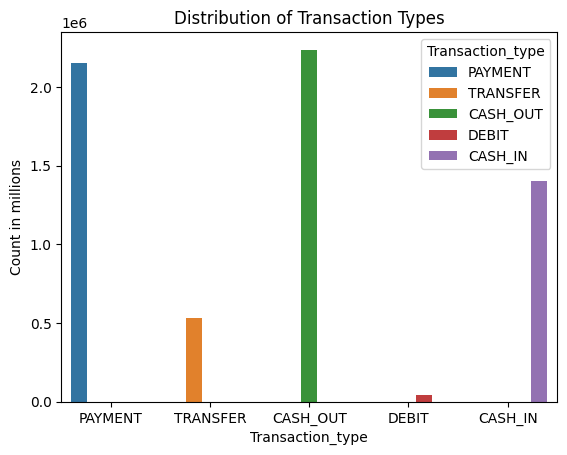

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: Transaction_type, dtype: int64

 Transaction types PAYMENT and CASH_OUT have the highest occurence contributing to 68.980938669919% of the data


In [21]:
# Histogram of Independent Categorical Variable - Transaction_type

val_counts = pd.value_counts(df_original.Transaction_type)
type_count = sns.countplot(data=df_original, x="Transaction_type", hue="Transaction_type")
type_count.set_title("Distribution of Transaction Types")
type_count.set_ylabel("Count in millions")
plt.show()
print(val_counts)
print("\n Transaction types PAYMENT and CASH_OUT have the highest occurence contributing to {}% of the data".format(((val_counts[0] + val_counts[1])/df_original.shape[0])*100))

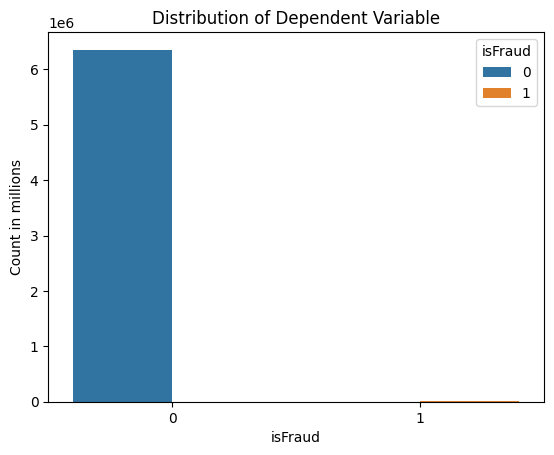

0    6354407
1       8213
Name: isFraud, dtype: int64

 Classes are highly imbalanced with Non-Fraud observations constituting 99.87091795518198% of the data


In [22]:
# Histogram of Dependent Variable - isFraud

target_val_counts = pd.value_counts(df_original.isFraud)
target_count = sns.countplot(data=df_original, x="isFraud", hue="isFraud")
target_count.set_title("Distribution of Dependent Variable")
target_count.set_ylabel("Count in millions")
plt.show()
print(target_val_counts)
print("\n Classes are highly imbalanced with Non-Fraud observations constituting {}% of the data".format(target_val_counts[0]/df_original.shape[0]*100))

#### What are the likely distributions of the numeric variables?

In [23]:
# List of Numeric Columns

numeric_columns

['Time_step_in_Hours',
 'Transaction_amount',
 'Sender_Acc_Bal_prior_Transaction',
 'Sender_Acc_Bal_post_Transaction',
 'Recipient_Acc_Bal_prior_Transaction',
 'Recipient_Acc_Bal_post_Transaction']

In [24]:
# Function to plot distributions (Density plot and Box Plot)

def Dist_Plot(df, column, title, xLabel, yLabel, mul_factor, amount_limit, time_step=False):
    # Create a facetgrid of 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [.70, .30]})

    # Density plot
    bins_var = [0]
    if time_step == True:
        mul_factor = 15
        amount_limit = 50
        for i in range(1,amount_limit):
            bins_var.append(i*mul_factor)
    else:
        for i in range(1,amount_limit):
            bins_var.append(i*mul_factor)

    amt_plot = sns.histplot(data=df, x=column, ax=ax[0], bins=bins_var)
    ax[0].axvline(df[column].mean(), color='r', linestyle='--')
    amt_plot.set_xlabel(xLabel)
    amt_plot.set_ylabel(yLabel)
    amt_plot.set_title(title)

    # Box Plot
    amt_box = sns.boxplot(y=column, data=df, ax=ax[1])
#     amt_box.set_ylabel(yLabel)
    # amt_box.set_title("Distribution of Transaction Amount")
    plt.show()

    # Get the outlier percentage for the independent variable
    outliers = boxplot_stats(df[column])[0]['fliers']
    print("Percentage of Oultliers based on Inter Quartile Range {}%".format((len(outliers)/df.shape[0])*100))





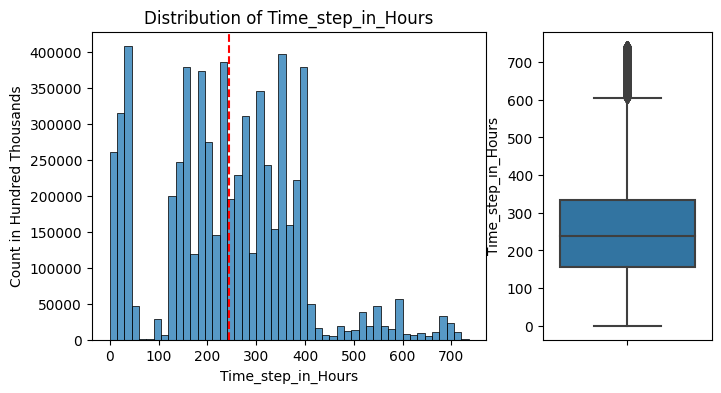

Percentage of Oultliers based on Inter Quartile Range 1.6139263385209237%


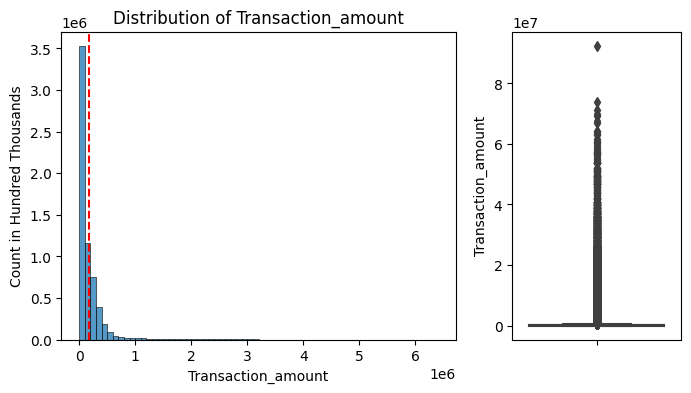

Percentage of Oultliers based on Inter Quartile Range 5.313502928039078%


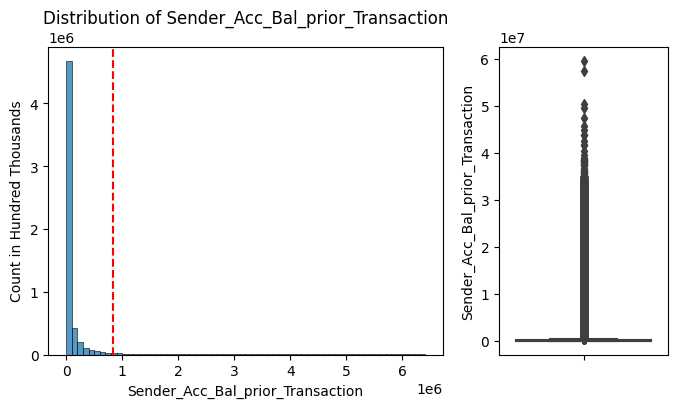

Percentage of Oultliers based on Inter Quartile Range 17.485045468690572%


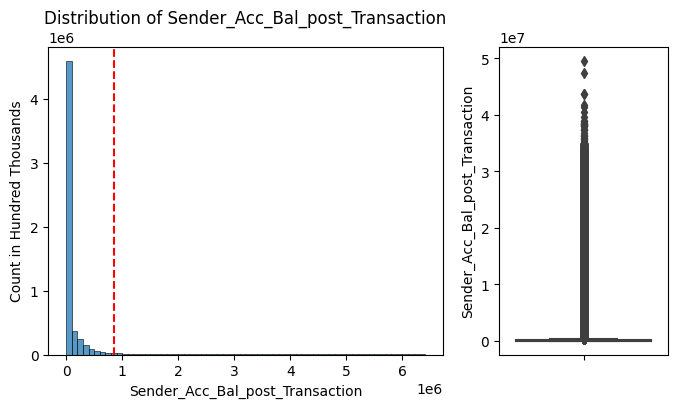

Percentage of Oultliers based on Inter Quartile Range 16.5559313616089%


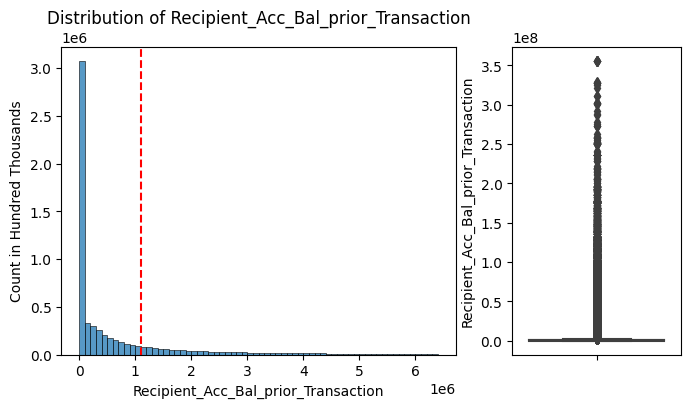

Percentage of Oultliers based on Inter Quartile Range 12.355523353587044%


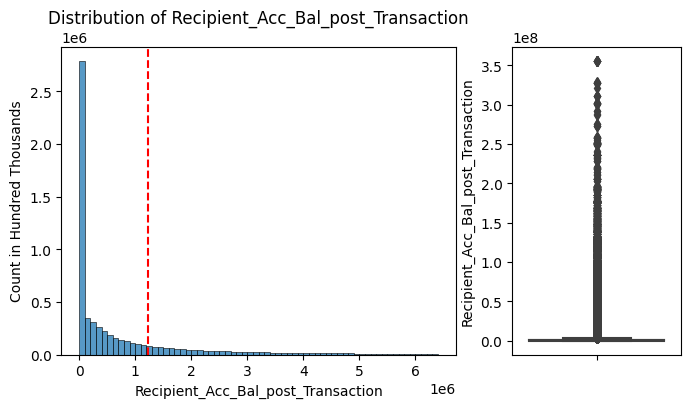

Percentage of Oultliers based on Inter Quartile Range 11.60727813385052%


In [25]:
# Plot the distribution of numerical variables

for i in numeric_columns:
    time_step = False
    if i == 'Time_step_in_Hours':
        time_step = True
    Dist_Plot(df_original,i,"Distribution of "+i, i, "Count in Hundred Thousands", 100000, 65, time_step)
    print("===============================================================")

#### Summary of Numeric Variable Distributions

* As observed from the Density Graphs, it is evident that the data is skewed for all numeric variables expect Time_step_in_Hours
* All the numeric variables have extreme outliers as seen from the Box plot except Time_step_in_Hours

Due to the presence of these extreme outliers, the modelling process can be affected. So to handle this situation, we can transform the data using Robust Scaler (works by subtracting the median from each value of the variable and then dividing it by inter quartile range) to reduce the errors in modelling.

In [26]:
# Robust Scaler

robust_transform = RobustScaler(with_centering=False, with_scaling=True)

transform_array = robust_transform.fit_transform(df_original.loc[:,numeric_columns])

# Create a dataframe of transformed numerical variables
df_transform = pd.DataFrame(transform_array, columns=numeric_columns)

# Concatenate the categorical variable (Transaction_type) to the transform dataframe
df_transform = pd.concat([df_transform, df_original.Transaction_type], axis=1)


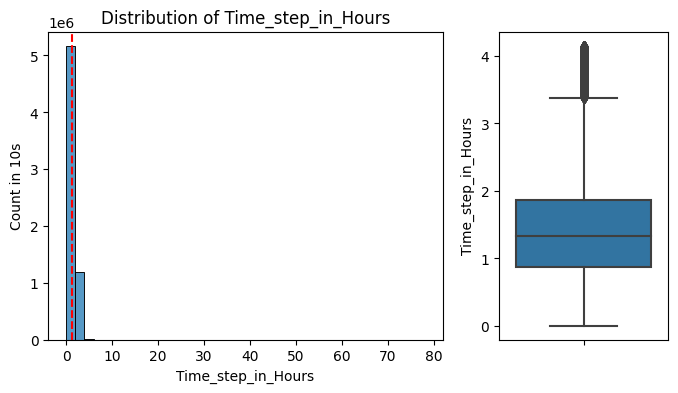

Percentage of Oultliers based on Inter Quartile Range 1.6139263385209237%


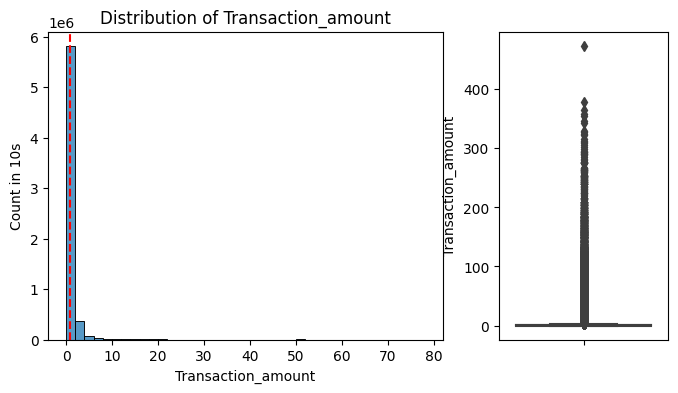

Percentage of Oultliers based on Inter Quartile Range 5.313502928039078%


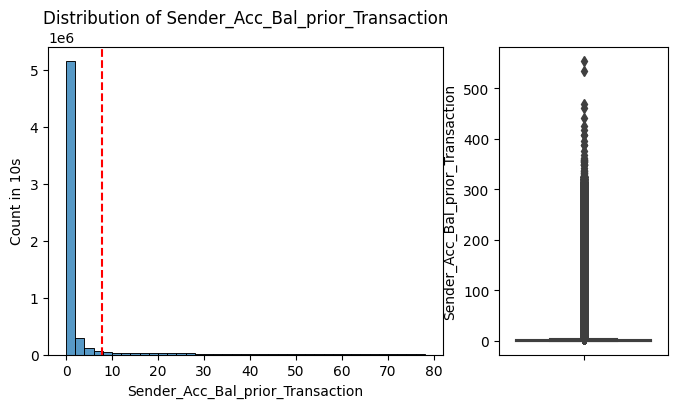

Percentage of Oultliers based on Inter Quartile Range 17.485045468690572%


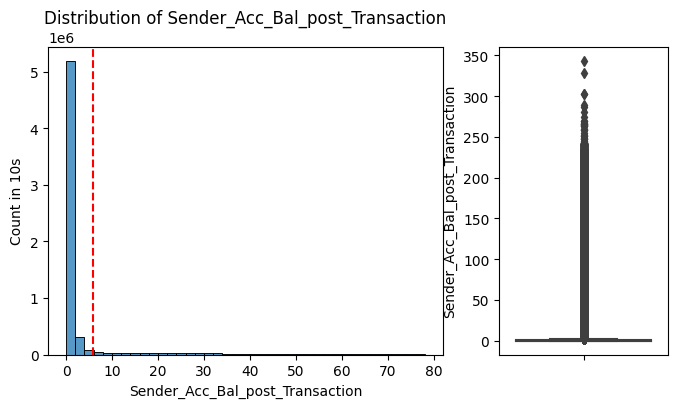

Percentage of Oultliers based on Inter Quartile Range 16.5559313616089%


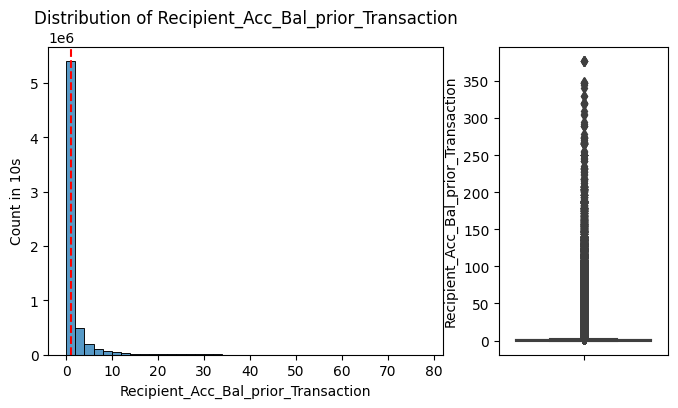

Percentage of Oultliers based on Inter Quartile Range 12.355523353587044%


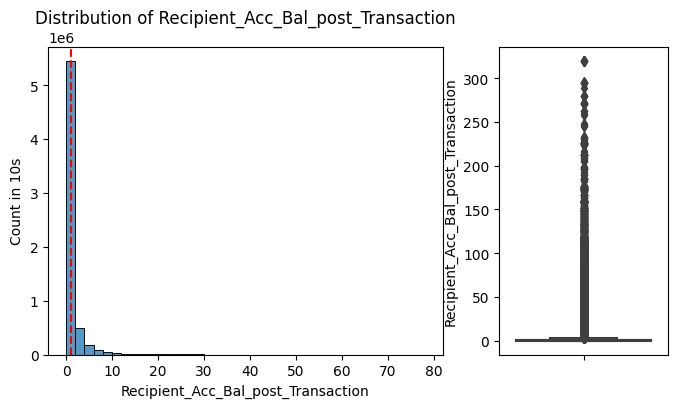

Percentage of Oultliers based on Inter Quartile Range 11.60727813385052%


In [27]:
# Plot the distribution of numerical variables after transformation

for i in numeric_columns:
    Dist_Plot(df_transform,i,"Distribution of "+i, i, "Count in 10s", 2, 40, False)
    print("===============================================================")

#### Summary of transformed Numeric Variable Distributions

* As observed from the Density Graphs, it is evident that the data is skewed for all numeric variables
* All the numeric variables have extreme outliers as seen from the Box plot except Time_step_in_Hours

It is evident from the graphs above that after transforming the data using Robust Scaler the influence of outliers is still high. As a next step we can remove the outliers from the data and then plot the numeric variables to further understand their distributions.

In [28]:
### Remove outliers from Data based on Inter Quartile Range(IQR)

##IQR = Quartile3 – Quartile1
## Function to identify outliers.
## Returns lists of row numbers of upper outliers and lower outliers for each numeric variable

def IQR(df, column):

    # Calculate Quartile 1 and Quartile 3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Inter Quartile Range
    IQR = Q3 - Q1

    # Calculate the upper and lower limits
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df[column]>=upper)[0]
    lower_array = np.where(df[column]<=lower)[0]

    return upper_array, lower_array


In [29]:
# Function to plot histogram of Class Distribution of Outliers present in numeric variables

def Plot_Hist_Class_Outlier(class_list, column):

    plt.figure(figsize=(4,4))
    plt.xlabel('Classes')
    plt.xticks([0,1])
    plt.title('Class Distribution of Outliers present in ' + column)
    plt.ylabel('Class Count in Thousands')
    plt.hist(class_list)
    plt.show()

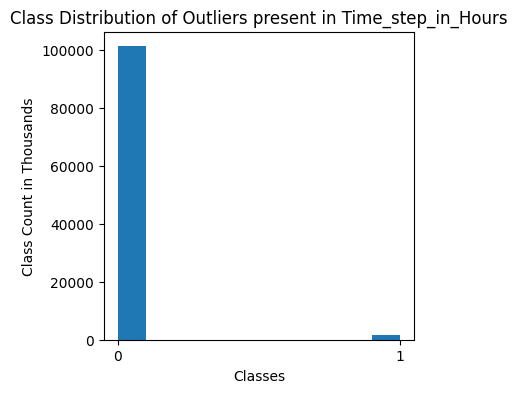

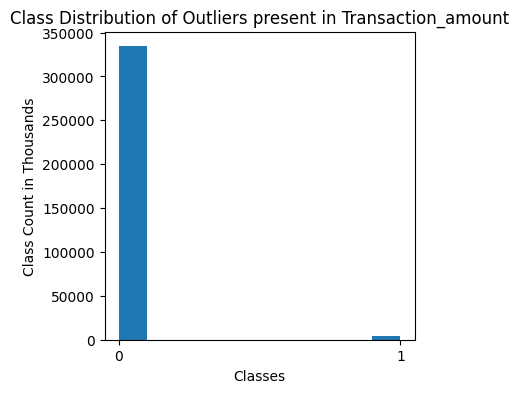

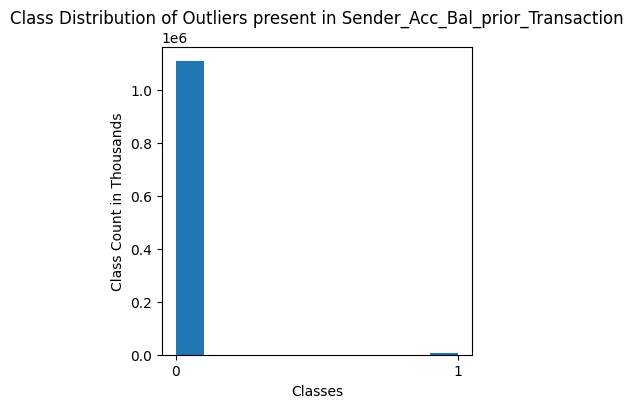

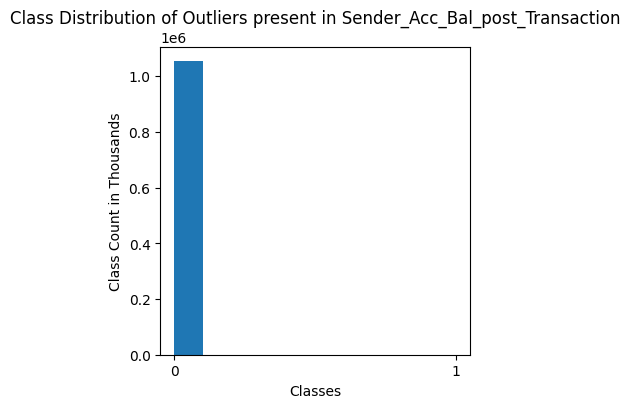

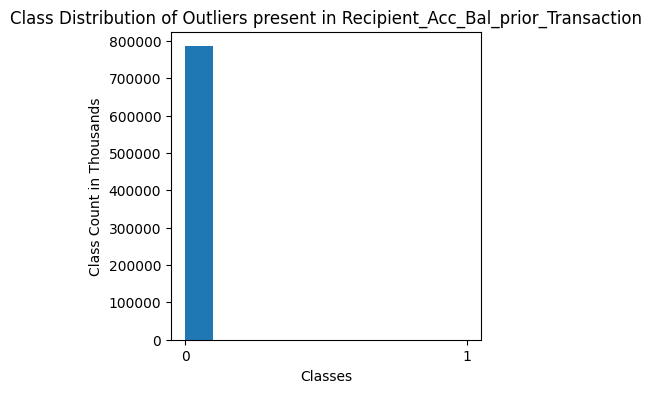

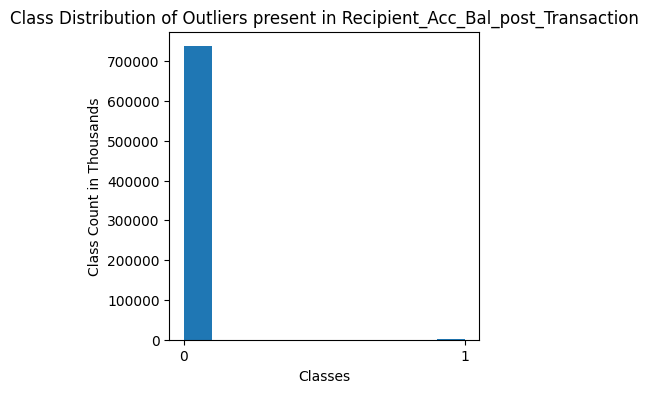

In [30]:
# Get the class distribution of Outliers for each numeric variable

# List to store outliers cross each numeric column
outliers = []

# iterate over numeric columns
for col in numeric_columns:

    # Call IQR function to get upper and lower outliers
    upper_array, lower_array = IQR(df_original, col)

    class_labels = []

    # check if the outlier list is empty
    if len(upper_array) > 0:
        for i in upper_array:

            # get class labels for each outlier using row number
            c_label = df_original['isFraud'][i]
            if c_label == 0:
                outliers.append(i)
            class_labels.append(df_original['isFraud'][i])

        # Function to plot histogram of classes
        Plot_Hist_Class_Outlier(class_labels, col)



From the Histograms above it is observed that most of the outliers across all numeric variables are present in the Non Fraud Class. And since our classes are highly imbalanced as evident from the exploratory data analysis, where Non-Fraud classes contribute to the major portion of our data, we can currently remove outliers belongin to Non Fraud classes

In [31]:
# Removing Outliers from the Data
outliers = list(set(outliers))

# make a copy of original data for further analysis before removing outliers
df_original_copy = df_original.copy()

# Remove outliers
df_original = df_original.drop(df_original.index[outliers], axis=0)



In [32]:
# Dataframe after removing outliers

df_original


,Time_step_in_Hours,Transaction_type,Transaction_amount,Sender_Id,Sender_Acc_Bal_prior_Transaction,Sender_Acc_Bal_post_Transaction,Recipient_Id,Recipient_Acc_Bal_prior_Transaction,Recipient_Acc_Bal_post_Transaction,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


#### Distributions of Independent Variables after removal of outliers

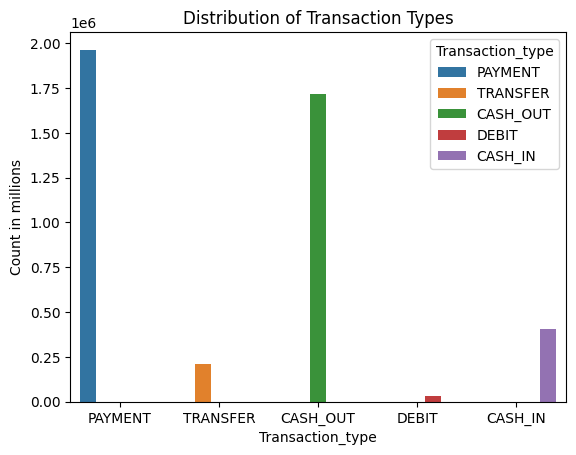

PAYMENT     1964804
CASH_OUT    1718314
CASH_IN      404209
TRANSFER     208254
DEBIT         32038
Name: Transaction_type, dtype: int64

 Transaction types PAYMENT and CASH_OUT have the highest occurence contributing to 85.10726105971898% of the data


In [33]:
# Histogram of Independent Categorical Variable - Transaction_type

val_counts = pd.value_counts(df_original.Transaction_type)
type_count = sns.countplot(data=df_original, x="Transaction_type", hue="Transaction_type")
type_count.set_title("Distribution of Transaction Types")
type_count.set_ylabel("Count in millions")
plt.show()
print(val_counts)
print("\n Transaction types PAYMENT and CASH_OUT have the highest occurence contributing to {}% of the data".format(((val_counts[0] + val_counts[1])/df_original.shape[0])*100))

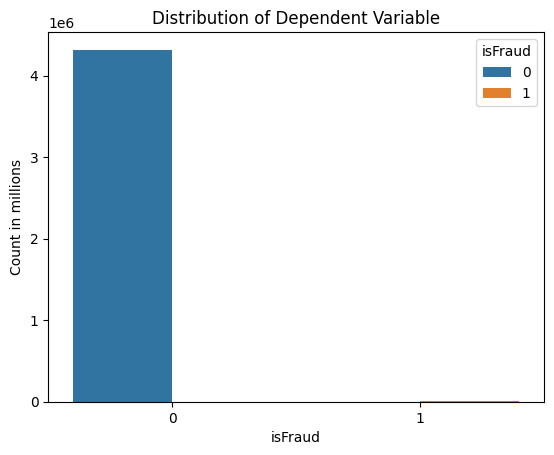

0    4319406
1       8213
Name: isFraud, dtype: int64

 Classes are highly imbalanced with Non-Fraud observations constituting 99.81021896798217% of the data


In [34]:
# Histogram of Dependent Variable - isFraud

target_val_counts = pd.value_counts(df_original.isFraud)
target_count = sns.countplot(data=df_original, x="isFraud", hue="isFraud")
target_count.set_title("Distribution of Dependent Variable")
target_count.set_ylabel("Count in millions")
plt.show()
print(target_val_counts)
print("\n Classes are highly imbalanced with Non-Fraud observations constituting {}% of the data".format(target_val_counts[0]/df_original.shape[0]*100))

There is no significant change in the distribution of classes after removal outliers from Non-Fraud class.

With outliers:
* Non-Fraud class (0) - 99.88%
* Fraud class (1) - 0.12 %

Without outliers:
* Non-Fraud class (0) - 99.81%
* Fraud class (1) - 0.19 %

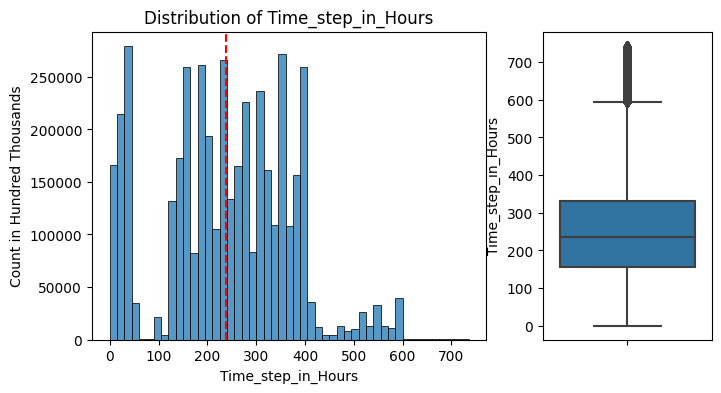

Percentage of Oultliers based on Inter Quartile Range 0.49364327127688457%


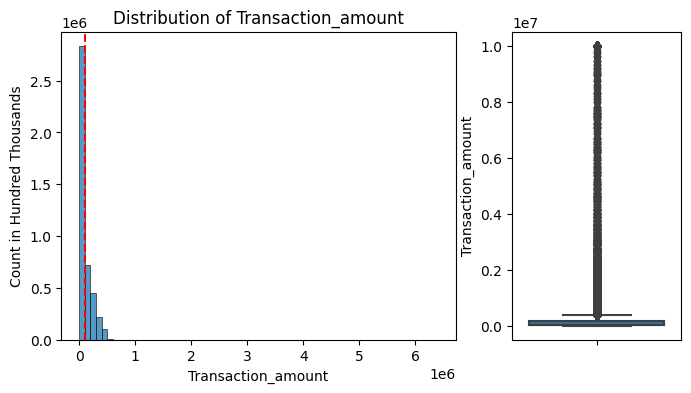

Percentage of Oultliers based on Inter Quartile Range 3.5157207693191106%


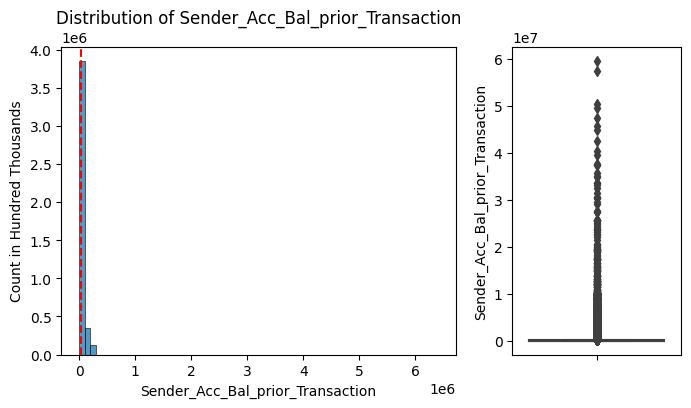

Percentage of Oultliers based on Inter Quartile Range 12.070771479651974%


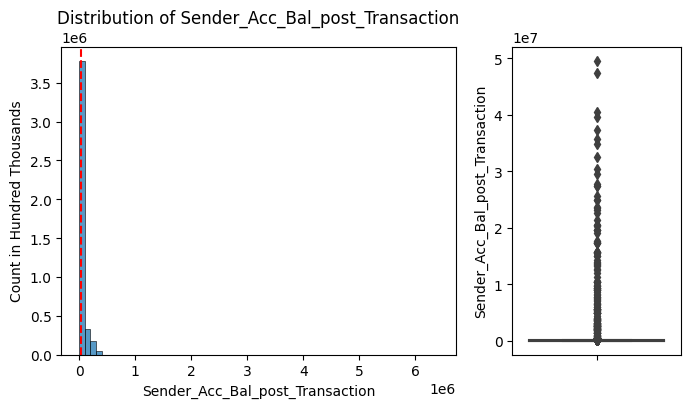

Percentage of Oultliers based on Inter Quartile Range 18.30590909227453%


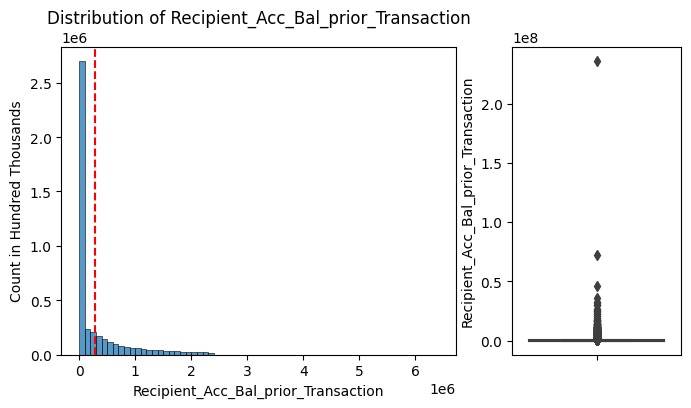

Percentage of Oultliers based on Inter Quartile Range 11.840483184864471%


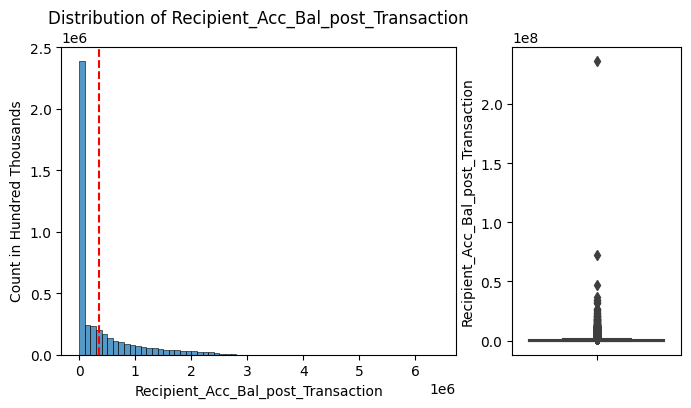

Percentage of Oultliers based on Inter Quartile Range 9.389065904369124%


In [35]:
# Distribution of Numeric Variables

for i in numeric_columns:
    time_step = False
    if i == 'Time_step_in_Hours':
        time_step = True
    Dist_Plot(df_original,i,"Distribution of "+i, i, "Count in Hundred Thousands", 100000, 65, time_step)
    print("===============================================================")

The outliers shown in the boxplots for the above graph belong to the Fraud Class. We have retained these outliers since this class has very small number of observations, hence removing outliers from this class would decrease the data size and impact the variance of data and affect the process of building the model.


### Feature Selection

In [36]:
# Dummy Encoding Categorical variable - Transaction_type

type_dummy = pd.get_dummies(df_transform, prefix='Transaction_type')
df_transform = pd.concat([type_dummy, df_original_copy.isFraud], axis=1)
df_transform



,Time_step_in_Hours,Transaction_amount,Sender_Acc_Bal_prior_Transaction,Sender_Acc_Bal_post_Transaction,Recipient_Acc_Bal_prior_Transaction,Recipient_Acc_Bal_post_Transaction,Transaction_type_CASH_IN,Transaction_type_CASH_OUT,Transaction_type_DEBIT,Transaction_type_PAYMENT,Transaction_type_TRANSFER,isFraud
0,0.005587,0.050374,1.585386,1.111175,0.000000,0.000000,0,0,0,1,0,0
1,0.005587,0.009544,0.198006,0.134375,0.000000,0.000000,0,0,0,1,0,0
2,0.005587,0.000927,0.001687,0.000000,0.000000,0.000000,0,0,0,0,1,1
3,0.005587,0.000927,0.001687,0.000000,0.022461,0.000000,0,1,0,0,0,1
4,0.005587,0.059735,0.387215,0.207169,0.000000,0.000000,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,4.150838,1.739000,3.165276,0.000000,0.000000,0.305494,0,1,0,0,0,1
6362616,4.150838,32.311205,58.811899,0.000000,0.000000,0.000000,0,0,0,0,1,1
6362617,4.150838,32.311205,58.811899,0.000000,0.072626,5.737787,0,1,0,0,0,1
6362618,4.150838,4.351581,7.920618,0.000000,0.000000,0.000000,0,0,0,0,1,1


#### Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

We will be using 3 methods to understand the most important features from the Dataset
* Principal Component Analysis - PCA
* Random Forest
* XGBoost


##### Principal Component Analysis - PCA

([<matplotlib.axis.XTick at 0x7e2b6fe7be20>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

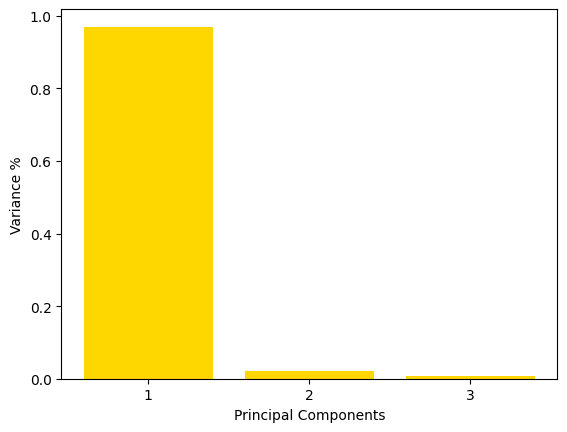

In [37]:
## PCA

pca = PCA(n_components=3)
pca.fit(df_transform)

# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

In [38]:
# Variable Importance table
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=df_transform.columns,index=PCnames)
Loadings

,Time_step_in_Hours,Transaction_amount,Sender_Acc_Bal_prior_Transaction,Sender_Acc_Bal_post_Transaction,Recipient_Acc_Bal_prior_Transaction,Recipient_Acc_Bal_post_Transaction,Transaction_type_CASH_IN,Transaction_type_CASH_OUT,Transaction_type_DEBIT,Transaction_type_PAYMENT,Transaction_type_TRANSFER,isFraud
PC1,-0.000239,-0.000387,0.798841,0.601436,0.007277,0.004231,0.006326,-0.002899,-0.000052,-0.002688,-0.000687,0.000004
PC2,0.004763,0.331657,-0.005442,-0.005466,0.684119,0.648949,0.001994,0.008781,0.000058,-0.023136,0.012302,0.000092
PC3,0.002147,0.929769,0.025201,-0.027922,-0.347817,-0.109406,-0.004747,-0.010648,-0.000855,-0.013003,0.029253,0.001104


##### Random Forest

In [39]:
# Create a feature set and target variable
X = df_transform.loc[:, df_transform.columns != 'isFraud']
y = pd.Categorical(df_transform['isFraud'])

feature_names = X.columns

# Run Random Forest Classifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)


<ipython-input-39-25cfe96df148>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  y = pd.Categorical(df_transform['isFraud'])


RandomForestClassifier(random_state=0)

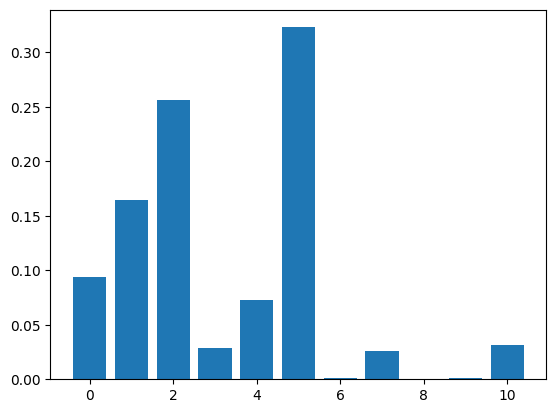

In [42]:
# Variable Importance Plot

forest_importances = pd.Series(forest.feature_importances_, index=feature_names)
plt.bar([x for x in range(len(forest_importances))], forest_importances)
plt.show()

In [41]:
# Variable Importance Table
forest_importances


NameError: ignored

##### XGBoost

In [ ]:
## XGBoost Classifier
xgboost = GradientBoostingClassifier()
xgboost.fit(X, y)

## Get Variable Importance Plot
xgboost_importances = pd.Series(xgboost.feature_importances_, index=feature_names)
plt.bar([x for x in range(len(xgboost_importances))], xgboost_importances)
plt.show()

In [ ]:
 # Variable Importance table
 xgboost_importances

Based on the variable importance plots the variables below are useful for training the model
* Time_step_in_Hours                     
* Transaction_amount                     
* Sender_Acc_Bal_prior_Transaction       
* Sender_Acc_Bal_post_Transaction        
* Recipient_Acc_Bal_prior_Transaction    
* Recipient_Acc_Bal_post_Transaction     
* Transaction_type_CASH_OUT              
* Transaction_type_TRANSFER  

### Which independent variables have missing data? How much?

From our analysis from the EDA section it is observed that None of the predictor variables have missing data

### Is the predictor variables independent of all the other predictor variables?

#### Pairwise Correlation

Running Pairwise Correlation to check if there are any relationships between independent variables

In [ ]:
# Compute the correlation matrix
corr = df_transform.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the Pairwise correlation plot it is evident that there are no pairs of variables that are highly correlated with each other

#### Which predictor variables are the most important?

Based on the variable importance plots the variables below are useful for training the model

* Time_step_in_Hours                     
* Transaction_amount                     
* Sender_Acc_Bal_prior_Transaction       
* Sender_Acc_Bal_post_Transaction        
* Recipient_Acc_Bal_prior_Transaction    
* Recipient_Acc_Bal_post_Transaction     
* Transaction_type_CASH_OUT              
* Transaction_type_TRANSFER  

#### Do the ranges of the predictor variables make sense?

Most of the predictor variables have ranges between $100000-$200000 as observed from the distributions and Box plots , except for a few outliers, some of which belong to the Fraudulent class, hence these are retained while performing the analysis.

#### What are the distributions of the predictor variables?

Most of the predictor variables have skewed distribution as observed from the box plots and distributions after performing transformation and removing outlier

### Do the training and test sets have the same data?

We will be performing stratefied sampling to get the Train and Test Split as this would ensure that the test set has a significant amount of observations from both classes and help provide a variance similar to the train data

In [ ]:
### Train and Test split of Data containing Outliers

# Defining features to train the model and target variable to predict
X = df_transform[['Transaction_amount', 'Sender_Acc_Bal_prior_Transaction',
       'Sender_Acc_Bal_post_Transaction',
       'Recipient_Acc_Bal_prior_Transaction',
       'Recipient_Acc_Bal_post_Transaction', 'Transaction_type_CASH_IN',
       'Transaction_type_CASH_OUT', 'Transaction_type_DEBIT',
       'Transaction_type_PAYMENT', 'Transaction_type_TRANSFER',]]
y = pd.Categorical(df_transform['isFraud'])


# Performing Stratefied Sampling to generate a test set with 25% samples from each class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_transform[['isFraud']])



In [ ]:
# Function to plot distributions of Train and Test data

def Plot_Dis(df, column, title, xLabel, yLabel, mul_factor, amount_limit, bar_color, time_step=False):

    # Density plot
    bins_var = [0]
    if time_step == True:
        mul_factor = 15
        amount_limit = 50
        for i in range(1,amount_limit):
            bins_var.append(i*mul_factor)
    else:
        for i in range(1,amount_limit):
            bins_var.append(i*mul_factor)

    amt_plot = sns.histplot(data=df, x=column, bins=bins_var, color=bar_color)
    amt_plot.set_xlabel(xLabel)
    amt_plot.set_ylabel(yLabel)
    amt_plot.set_title(title)


# Iterate over numeric columns
for i in X_train.columns:


    Plot_Dis(X_train, i, "Distribution of Train and Test data for variable "+ i,i, 'Count in 10s of Dollars', 2, 40, 'green',time_step=False)

    Plot_Dis(X_test, i, "Distribution of Train and Test data for variable "+i,i, 'Count in 10s of Dollars', 2, 40, 'orange',time_step=False)
    plt.legend(loc='upper right', labels=['Train', 'Test'])
    plt.figure(figsize=(6,6))
    plt.show()




In [ ]:
### Train and Test split of Data after removing Outliers

df_original_no_out  = df_original.select_dtypes(include=['float64','int64'])
df_original_no_out = pd.concat([df_original_no_out, df_original['Transaction_type']], axis=1)

# Dummy Encoding Categorical variable - Transaction_type

type_dummy = pd.get_dummies(df_original_no_out, prefix='Transaction_type')
df_original_no_out = pd.concat([type_dummy, df_original.isFraud], axis=1)
df_original_no_out


In [ ]:
# Defining features to train the model and target variable to predict

X = df_original_no_out[['Transaction_amount', 'Sender_Acc_Bal_prior_Transaction',
       'Sender_Acc_Bal_post_Transaction',
       'Recipient_Acc_Bal_prior_Transaction',
       'Recipient_Acc_Bal_post_Transaction', 'Transaction_type_CASH_IN',
       'Transaction_type_CASH_OUT', 'Transaction_type_DEBIT',
       'Transaction_type_PAYMENT', 'Transaction_type_TRANSFER',]]
y = pd.Categorical(df_original_no_out['isFraud'])


# Performing Stratefied Sampling to generate a test set with 25% samples from each class
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_original_no_out[['isFraud']])


In [ ]:
# Plotting the distribution plot for train and test data

# Iterate over numeric columns
for i in X_train_no_out.columns:


    Plot_Dis(X_train_no_out, i, "Distribution of Train and Test data for variable "+ i,i, 'Count in 10s of Dollars', 2, 40, 'green',time_step=False)

    Plot_Dis(X_test_no_out, i, "Distribution of Train and Test data for variable "+i,i, 'Count in 10s of Dollars', 2, 40, 'orange',time_step=False)
    plt.legend(loc='upper right', labels=['Train', 'Test'])
    plt.figure(figsize=(6,6))
    plt.show()


### Classification

We will be using Logistic Regression Model to perform classification as the dataset has only 2 classes (Binary Classification).

#### Remove outliers and keep outliers (does if have an effect of the final predictive model)?

Initially we will fit the model using data containing outliers and then fit the model on data that doesn't contain outliers to compare the influence of outliers on  the prediction task.



In [ ]:
# Logistic Regression Model for Binary Classification

def Logit_Regression(X_train, y_train, X_test,y_test):
    # Define the model
    model = LogisticRegression(solver='liblinear', random_state=0)

    # Fit the model to train data
    model.fit(X_train, y_train)

    # Generate predictions on test
    y_pred = model.predict(X_test)

    # Get the accuracy of the model
    print("Accuracy : {}".format(round(model.score(X_test,y_test),3)))

    # Generate Confusion matrix

    conf_mat = confusion_matrix(y_test, model.predict(X_test))
    Conf_plot = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    Conf_plot.plot()
    plt.show()

    # Generate report of classification
    report = classification_report(y_test, y_pred)
    print(report)

In [ ]:
# Running Logistic Regression function on Data containing Outliers

Logit_Regression(X_train, y_train, X_test,y_test)


In [ ]:
# Running Logistic Regression function on Data containing Outliers
Logit_Regression(X_train_no_out, y_train_no_out, X_test_no_out,y_test_no_out)


# References
* Rescaling the Data - https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
* Pairwise Correlation Matrix - https://seaborn.pydata.org/examples/many_pairwise_correlations.html
* Visualizing distributions of data - https://seaborn.pydata.org/tutorial/distributions.html
* Sklearn Metrics - https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
* Logistic Regression - https://realpython.com/logistic-regression-python/
* PCA - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
* Random Forest - https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* XGBoost - https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/